In [1]:
# FUGU code module
# JBA (jbaimon@sanida.)

import networkx as nx
import matplotlib.pyplot as plt
from math import log, ceil
import numpy as np
import brick_1
# import FuguBricks  Eventually we need to move all the bricks into FuguBricks

In [2]:
class Module:
    """Base class for all Fugu Modules"""

    def __init__(self):
        self.module=nx.DiGraph()
        self.N_in=0
        self.N_out=0
        self.T_in=0
        self.T_out=0
        self.D=0

    def getCoding():
        # Provide a description of neural coding scheme for input and output of the module
        input_coding='binary-big'
        output_coding='binary-big'
        input_precision=1
        output_precision=8
        return input_coding, output_coding, input_precision, output_precision
    
    def resolveParams(N_in, **kwargs):
        # resolveParams should provide a real-time estimation / determination of the requisite sizes, times, and depth of module bricks
        # ideally; this does not include building the graph, which should be done elsewhere
        D_bias=0
        if(kwargs.get("D")):
            D_bias=kwargs[D]
            
        N_in=N_in
        N_out=2*N_in
        T_in=1
        T_out=1
        D=2+ceil(log(N_in))
        return N_out, T_in, T_out, D
    
    def buildModule(N_in, N_out, T_in, T_out, D):
        pass
        
class Delay:
    """Base class for all Fugu Modules"""

    def __init__(self):
        self.module=nx.DiGraph()
        self.N_in=0
        self.N_out=0
        self.T_in=0
        self.T_out=0
        self.D=0

    def resolveParams(N_in, **kwargs):
        # resolveParams should provide a real-time estimation / determination of the requisite sizes, times, and depth of module bricks
        # ideally; this does not include building the graph, which should be done elsewhere
        D_bias=0
        if(kwargs.get("D")):
            D_bias=kwargs[D]
            
        N_in=N_in
        N_out=N_in
        T_in=1
        T_out=1
        D=D_bias
        return N_out, T_in, T_out, D
    
    def buildModule(N_in, N_out, T_in, T_out, D):
        pass
        

In [4]:
class Scaffold:
    def __init__(self):
        self.circuit=nx.DiGraph()
        # ct = number of nodes in scaffold
        self.ct=0  
        self.pos={}
        
    def add_brick(self, brick_func, input_node=-1, N_in=0):
        self.circuit.add_node(self.ct, func=brick_func, N_in=N_in, N_out=0, T_in=0, T_out=0, D=0, layer='output', input_coding='unknown', output_coding='unknown')
        if type(input_node) is list:
            # Condition where there are multiple input nodes
            old_pos=0
            for i in input_node:
                old_pos=old_pos+self.pos[self.ct-1][1]
                self.circuit.add_edge(i, self.ct)
                if self.circuit.node[i]['layer']=='output':
                    self.circuit.node[i]['layer']='hidden'
            
            self.pos[self.ct]=np.array([self.ct, old_pos/(len(input_node)+1)])
            
        elif input_node=='input' or input_node<-1:
            # Condition where input node is null; Consider this an input layer
            nx.set_node_attributes(self.circuit, self.ct, 'input')
            self.circuit.node[self.ct]['layer']='input'
            self.pos[self.ct]=np.array([self.ct, 0])
            
            
        elif input_node==-1:
            # Condition where input node is simply previous node // DEFAULT
            self.circuit.add_edge(self.ct-1, self.ct)
            old_pos=self.pos[self.ct-1]
            self.pos[self.ct]=np.array([self.ct, old_pos[1]])
            if self.circuit.node[self.ct-1]['layer']=='output':
                self.circuit.node[self.ct-1]['layer']='hidden'
        elif type(input_node) is int:
            # Condition where input node is single and explicitly defined
            self.circuit.add_edge(input_node, self.ct)
            old_pos=self.pos[input_node]
            self.pos[self.ct]=np.array([self.ct, old_pos[1]+1])
            if self.circuit.node[input_node]['layer']=='output':
                self.circuit.node[input_node]['layer']='hidden'

        else:
            self.circuit.add_edge(input_node, self.ct)
            
            
        self.ct=self.ct+1
    
    def resolve_size_brick(self, input_node):
        # Ideally, the placement of nodes in add_brick above will automatically establish sizes
        pass
    
    def resolve_sizes(self):
        # Function to walk through scaffold and resolve sizes one function at a time.
        N=nx.number_of_nodes(self.circuit)
        M=nx.number_of_edges(self.circuit)
        func=self.circuit.node[0]['func']
        [N_out, T_in, T_out, D]=func.resolveParams(self.circuit.node[0]['N_in'])
        self.circuit.node[0]['N_out']=N_out
        self.circuit.node[0]['T_in']=T_in
        self.circuit.node[0]['T_out']=T_out
        self.circuit.node[0]['D']=D
        for i in range(1, N):
            # Starting with the 2nd node (node 1), define sizes based on input nodes' outputs and pass forward 
            N_in=0
            for j in self.circuit.predecessors(i):
                # Loop through all predecessor nodes to count number of inputs
                N_in=N_in+self.circuit.node[j]['N_out']
            
            self.circuit.node[i]['N_in']=N_in
            func=self.circuit.node[i]['func']
            [N_out, T_in, T_out, D]=func.resolveParams(self.circuit.node[i]['N_in'])
            self.circuit.node[i]['N_out']=N_out
            self.circuit.node[i]['T_in']=T_in
            self.circuit.node[i]['T_out']=T_out
            self.circuit.node[i]['D']=D
            
            # This will match sizes, not times!
        
    def resolve_timing(self):
        # Set weights to equal source node timing (T_out + D?)
        
        # From end to front
        #     Identify predecessor nodes; if 1, then pass, if >1, then compute longest path to each source
        #     If longest path size is different, then add delay node to shorter one to make equivalent.  
        
        # Have to define D as "time from first input within T_in to first output within T_out.  Have to assume T_in(2)= T_out(1)
        nodes = list(self.circuit.nodes()) 
        edges = list(self.circuit.edges())
        for edge in edges:
            self.circuit.edges[edge[0], edge[1]]['weight']=self.circuit.node[edge[0]]['D']

        for node in reversed(nodes):
            
            # loop backwards through nodes
            # Find predecessor node for 'node'
            pred_nodes=list(self.circuit.predecessors(node))
            print(node, list(pred_nodes), len(list(pred_nodes)), len(pred_nodes))
            
            if len(list(pred_nodes))<2:
                pass
            else:
                distances=[]
                for target_node in list(pred_nodes):
                    distance_guess=0
                    target_paths=nx.all_simple_paths(self.circuit, 0, target_node)
                    for path in map(nx.utils.pairwise, target_paths):
                        path_lengths=self.get_weight(path)
                        if path_lengths>distance_guess: distance_guess=path_lengths
                    
                    distance_guess=distance_guess+self.circuit.edges[target_node, node]['weight']
                    print(target_node, distance_guess)
                    distances.append(distance_guess)
                    
                # Now, we need to add delay nodes to paths less than longest distance
                
                max_value=max(distances)
                max_index=distances.index(max_value)
                print(list(distances), max_index, max_value)
                
                for i in range(0, len(pred_nodes)):
                    # Check if this path needs a delay node
                    if(distances[i]<max_value):
                        target_node=pred_nodes[i]
                        print('Adding delay node of length ', max_value-distances[i], 'between ', target_node, ' and ', node)
                        N_delay=self.circuit.nodes[target_node]['N_out']
                        self.circuit.add_node(target_node+0.5, func=Delay, N_in=N_delay, N_out=N_delay, T_in=1, T_out=1, D=max_value-distances[i], layer='delay')
                        self.pos[target_node+0.5]=np.array([target_node+0.5, self.pos[target_node][1]])
                        self.circuit.remove_edge(target_node, node)
                        self.circuit.add_edge(target_node, target_node+0.5, weight=self.circuit.nodes[target_node]['D'])
                        self.circuit.add_edge(target_node+0.5, node, weight=self.circuit.nodes[target_node+0.5]['D'])

    def plot(self):
        plt.subplot(111)
        G=self.circuit
        #pos=nx.spring_layout(G)
        pos=self.pos
        
        #color_map={'layer': ['input', 'hidden', 'delay', 'output'], 'color': ['r','g','y','b']}
        
        nx.draw_networkx_nodes(G, pos)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
        labels=nx.get_node_attributes(G, 'layer')
        labels=nx.get_node_attributes(G, 'N_in')
        
        nx.draw_networkx_labels(G, pos, labels, font_size=12)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
        #nx.draw(self.circuit, with_labels=True, font_weight='bold')
        plt.show()
        print(pos)
        
    def get_weight(self, path):
        total_len=0
        for i in list(path):
            total_len=total_len+self.circuit.edges[i]['weight']
        
        return total_len
    
    def lay_bricks(self):
        # Move through scaffold graphs and...
        #    1- build actual circuit from front to back
        #    2- replace edges from input neurons of each brick with edges from previous output neurons
        G=nx.DiGraph()
        nodes = list(self.circuit.nodes()) 
        edges = list(self.circuit.edges())
        for edge in edges:
            pass
        
        # Find the first input layer in graph
        input_bricks=[node_id for node_id, att in self.circuit.nodes() if att['layer']=='input']
        hidden_bricks=[node_id for node_id, att in self.circuit.nodes() if att['layer']=='hidden']
        output_bricks=[node_id for node_id, att in self.circuit.nodes() if att['layer']=='output']
        
        processed_bricks=[]
               
        # Put all input bricks into the final network
        for brick in input_bricks:
            func=self.circuit.node[brick]['func']
            H=func.buildBrick(N_in=self.circuit.node[brick]['N_in'], N_out=self.circuit.node[brick]['N_out'], T_in=self.circuit.node[brick]['T_in'], T_out=self.circuit.node[brick]['T_out'], D=self.circuit.node[brick]['D'])
            
            # Need to change names of nodes within H to represent being part of this specific brick
            
            # some python rename node IDs magic...
            
            # NetworkX compose function will combine two graphs, merging all nodes that overlap between graphs G and H.  Overlapping nodes will take attributes from the 2nd entry...
            G=nx.compose(H, G)
            processed_bricks.append(brick)
        
        for brick in hidden_bricks:
            
            # Look for predecessor nodes
            pred_nodes=list(self.circuit.predecessors(brick))
            
            # CHECK if pred_nodes are in processed bricks; if not, then need to skip this brick for now...
            
            brick_okay=True
            for pred in pred_nodes:
                if pred not in processed_bricks:
                    # Need to skip to next brick...
                    brick_okay=False
                    
            if brick_okay==False:
                break
            
            func=self.circuit.node[brick]['func']
            H=func.buildBrick(N_in=self.circuit.node[brick]['N_in'], N_out=self.circuit.node[brick]['N_out'], T_in=self.circuit.node[brick]['T_in'], T_out=self.circuit.node[brick]['T_out'], D=self.circuit.node[brick]['D'])
            
            # Need to change names of neuron nodes within H to represent being part of this specific brick
            
            # Need to change names of input neuron nodes within H to be the same as output neuron nodes in predessor brick
            
            # some python rename node IDs magic...
            
            # NetworkX compose function will combine two graphs, merging all nodes that overlap between graphs G and H.  Overlapping nodes will take attributes from the 2nd entry...
            G=nx.compose(H, G)
            processed_bricks.append(brick)
            
        # Need to go back through hidden bricks and try again until they are all processed...
        
        for brick in output_bricks:
            
            # Look for predecessor nodes
            pred_nodes=list(self.circuit.predecessors(brick))
            
            # CHECK if pred_nodes are in processed bricks; if not, then need to skip this brick for now...
            
            brick_okay=True
            for pred in pred_nodes:
                if pred not in processed_bricks:
                    # Need to skip to next brick...
                    brick_okay=False
                    
            if brick_okay==False:
                break
            
            func=self.circuit.node[brick]['func']
            H=func.buildBrick(N_in=self.circuit.node[brick]['N_in'], N_out=self.circuit.node[brick]['N_out'], T_in=self.circuit.node[brick]['T_in'], T_out=self.circuit.node[brick]['T_out'], D=self.circuit.node[brick]['D'])
            
            # Need to change names of neuron nodes within H to represent being part of this specific brick
            
            # Need to change names of input neuron nodes within H to be the same as output neuron nodes in predessor brick
            
            # some python rename node IDs magic...
            
            # NetworkX compose function will combine two graphs, merging all nodes that overlap between graphs G and H.  Overlapping nodes will take attributes from the 2nd entry...
            G=nx.compose(H, G)
            processed_bricks.append(brick)
        
        return G
        
class Circuit:
    """Prototype circuit class for Fugu - where we will build output Fugu networks"""
    
    
    
    def __init__(self):
        circuit_scaffold=nx.DiGraph()
    
    def add_brick(self, brick_func, *arg):
        # Function to add brick to circuit
        #
        # brick_func will call procedure to generate the subcircuit
        # * arg will be arguments to pass into brick_func, if appropriate
        n_nodes=self.circuit_abstract.number_of_nodes()
        self.circuit_abstract.add_node(n_nodes+1, )
        self.circuit_abstract.add_edge()
        

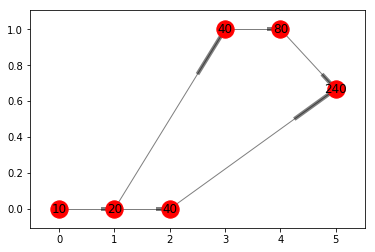

{0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 1]), 4: array([4, 1]), 5: array([ 5.        ,  0.66666667])}
5 [2, 4] 2 2
2 16
4 23
[16, 23] 1 23
Adding delay node of length  7 between  2  and  5
4 [3] 1 1
3 [1] 1 1
2 [1] 1 1
1 [0] 1 1
0 [] 0 0
5


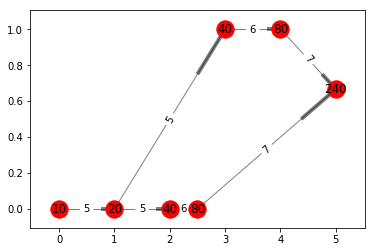

{0: array([0, 0]), 1: array([1, 0]), 2: array([2, 0]), 3: array([3, 1]), 4: array([4, 1]), 5: array([ 5.        ,  0.66666667]), 2.5: array([ 2.5,  0. ])}


In [5]:
a=Scaffold()
a.add_brick(Module,  'input', 10)
a.add_brick(Module)
a.add_brick(Module)
a.add_brick(Module, 1)
a.add_brick(Module)
a.add_brick(Module, [2, 4])
a.resolve_sizes()
a.plot()
a.resolve_timing()
b=list(a.circuit.nodes)
c=list(a.circuit.edges)
print(a.circuit.edges[0, 1]['weight'])
a.plot()
[b,c]
#r=(path for path in nx.all_simple_paths(a.circuit, 0, 5), key=lambda path: nx.get_weight(path))
paths=nx.all_simple_paths(a.circuit, 0, 5)
for path in map(nx.utils.pairwise, paths):
    a.get_weight(path)
    print(a)
    #for i in list(path):
    #        print(a.circuit.edges[i]['weight'])
